# Plot Figures 5, 6, 11 12


These figures show clustering metrics and PCA

For Sawi et al., 2021

## Todo::


* Why is cluster assignment changing in k-means even when I set random state to 0? Try 42??

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,catMergeFromH5,lagWF,calcCorr_template
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat, calcCorr_template, calcCCMatrix

from functions2 import getSpectra,getFP,getMaxIndexFP,calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF, lagWF
import figureFunctions2

## Set paths

In [3]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathFigSupp = '../reports/supp_figures/'
pathAuxData = '../data/processed/Garcia/'

## Load auxiliary catalog

In [4]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')



## Define some important times in study period

In [5]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [6]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [7]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [94]:
len(cat00),len(cat00N)
# BB_Gorner_Event_Final_v11_J8
# BB_Gorner_Cont_Final_v10_J8

(1411, 1521)

In [89]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [9]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [10]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [11]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [12]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 5 - Reduce dimensionality, visualize PC plots by time, hour, cluster

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [13]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762943
3 0.277379352915
4 0.312981189656
5 0.343504128556
6 0.37257461147
7 0.39888893985
8 0.42088851329
9 0.439313155518
10 0.456410703313
11 0.472876248817
12 0.488664934363
13 0.503509959811
14 0.517469732388
15 0.53074926616
16 0.543710788992
17 0.556290325908
18 0.56842318394
19 0.580137989722
20 0.59130183239
21 0.602298717554
22 0.612567674465
23 0.621741557711
24 0.630973852359
25 0.639944982074
26 0.648552566943
27 0.656959265692
28 0.665203081602
29 0.672795897423
30 0.68052392032
31 0.687925178047
32 0.695144003163
33 0.701983119698
34 0.708719042652
35 0.71535412471
36 0.721897465059
37 0.728166996035
38 0.735115043689
39 0.741027061239
40 0.746868786558
41 0.752712395156
42 0.758576722858
43 0.763964571149
44 0.769359834319
45 0.774974389046
46 0.779994369898
47 0.784837376733
48 0.7895294129
49 0.794654043411
50 0.799076452611
51 0.803761404803
52 0.808167289815
53 0.812383483332
54 0.817069985386
55 0.820490850665
56 0.824866045528
57 0.828610

In [14]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.32% of variance explained by the first 67 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [15]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## PCA plot colored by datetime

In [16]:
hour_list = [h.hour for h in cat00.datetime]
hour_listN = [h.hour for h in cat00N.datetime]

cat00['hod'] = hour_list
cat00N['hod'] = hour_listN

In [17]:

series_datetime = cat00.datetime
series_datetimeN = cat00N.datetime


series_hour = cat00.hod
series_hourN = cat00N.hod


# Figure 6 - clustering results [using mean silh score, not median -- outliers should influence clustering]

## Clustering using Kmeans, validating using silhouette score

In [41]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)



cat00.to_csv('../data/interim/icequakes_k{Kopt}.csv')
cat00N.to_csv('../data/interim/noise_k{KoptN}.csv')



kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


In [42]:
for k in range(1,Kopt+1):
    print(len(cat00[cat00.Cluster==k]))

    
print('\n')
for k in range(1,KoptN+1):
    print(len(cat00N[cat00N.Cluster==k]))

164
445
802


352
601
353
215


## Plot PCA with {topF} most representative events

In [43]:
topF = 20

catRep = getTopFCat(cat00,topF=topF)

catRepN = getTopFCat(cat00N,topF=topF)

# Plot 5 -- PCA with cluster assignment

3 4


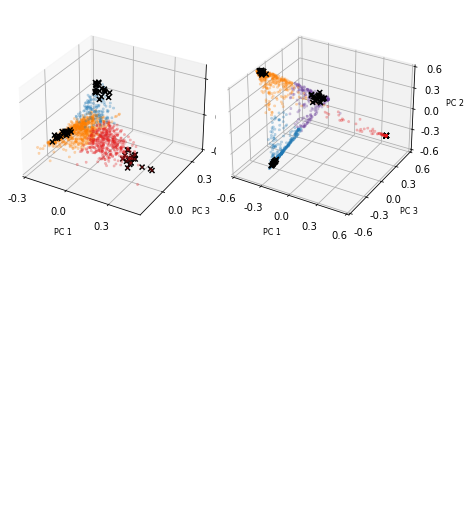

In [61]:
## Plot PCA by datetime, show rep events
tfont=14
plt.rcParams.update({'font.size': 10})


print(Kopt,KoptN)

fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')


size_dot = 4
alpha_dot = .3
size_rep = 25

label_fontsize = fontsize = 8





ax = fig.add_subplot(221, projection='3d')
figureFunctions2.plotPCA(cat00,catRep,Kopt, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=fontsize,ax=ax, fig=fig, **plt_kwargs)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)




ax = fig.add_subplot(222, projection='3d')
figureFunctions2.plotPCA(cat00N,catRepN,KoptN, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=fontsize,ax=ax, fig=fig, **plt_kwargs)



plt.subplots_adjust(wspace=0,hspace=0.1)




plt.savefig(pathFig + 'Figure_5.png')

### plot figure 5 silhScore

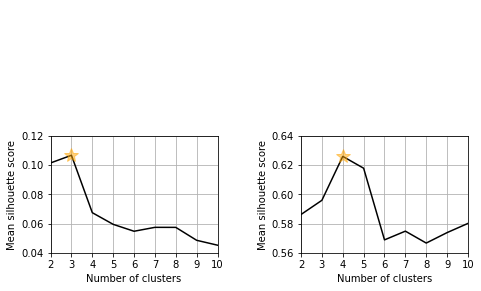

In [62]:
xlabelsize=10

fig,axes = plt.subplots(figsize = (width2,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')

### Plot silh Scores
ax = fig.add_subplot(223)
figureFunctions2.plotSilhScore(Kopt, avgSils, range_n_clusters_all,starSize=15,ax=ax)
ax.set_xlim(2,10)
ax.set_ylim(.04,.12)
ax.xaxis.label.set_size(xlabelsize)

ax = fig.add_subplot(224)
figureFunctions2.plotSilhScore(KoptN, avgSilsN, range_n_clusters_all,starSize=15,ax=ax)
plt.subplots_adjust(wspace=0.4,hspace=0.1)
ax.set_xlim(2,10)
ax.set_ylim(.56,.64)
ax.xaxis.label.set_size(xlabelsize)


plt.subplots_adjust(wspace=0.5,hspace=0.1)


plt.savefig(pathFig + 'Figure_5_silhScore.png')

# Figure 6 rep wf spectra and reconstructed spectra

In [66]:
# # Finding CC and Lag matrices for top {20} events
# shift_cc = lenData
# shift_ccN = lenDataN
# topF = 20
# catRep = getTopFCat(cat00,topF=topF) 
# catRepN = getTopFCat(cat00N,topF=topF)

# print(f'calculating IQ CC topF = {topF}...')
# cc_mat,lag_mat = calcCCMatrix(catRep,lenData,dataH5_path,station,channel,fmin,fmax,fs)

# print(f'calculating NS CC topF = {topF}...')

# cc_matN,lag_matN = calcCCMatrix(catRepN,lenDataN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)

# print(f'saving...')

# np.save(f'../data/interim/ccLagMat_top{topF}_SS.npy',lag_mat)
# np.save(f'../data/interim/ccLagMat_top{topF}_SS_N.npy',lag_matN)

# np.save(f'../data/interim/ccMat_top{topF}_SS.npy',cc_mat)
# np.save(f'../data/interim/ccMat_top{topF}_SS_N.npy',cc_matN)


calculating IQ CC topF = 20...
calculating NS CC topF = 20...
saving...


In [67]:
topF = 20 

catRep = getTopFCat(cat00,topF)
catRepN = getTopFCat(cat00N,topF)

lag_mat = np.load(f'../data/interim/ccLagMat_top{topF}_SS.npy')
lag_matN = np.load(f'../data/interim/ccLagMat_top{topF}_SS_N.npy')

lag_matN.shape

(80, 80)

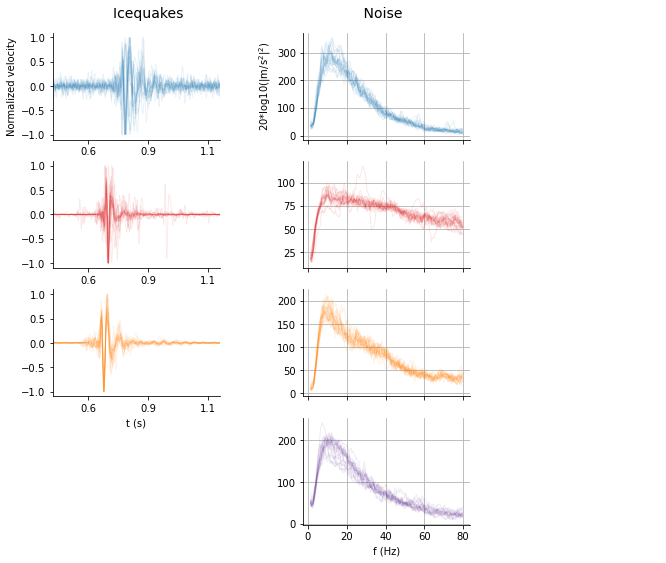

In [68]:
# plt.rcParams.update({'font.size': 8})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(4,2)
gs.update(wspace=.5)

tfont = 14
lw=.8
alpha=.1
    

for i, evID in enumerate(catRep.event_ID):    

        
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    date_str = str(catRep.datetime.iloc[i])[5:]
    k = catRep.Cluster.iloc[i]
    ax=plt.subplot(gs[k-1,0:1]);
    

    
    lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster
    
    
    # load wf from H5
    wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)
    
    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 0
    wf_offset = (wf_zeromean) + i*offset#1.5
    
    waveform_shift = lagWF(wf_offset, lag0, index_wf=i)
    ##plot !!

    plt.plot(waveform_shift,lw=lw,alpha=alpha,c=colors[k-1])

    if k==1:
        ax.set_ylabel('Normalized velocity')



# #### General
    ticks=[c for c in np.linspace(0,len(wf_zeromean),8)]
    ticklabels=[f'{c:.1f}' for c in np.linspace(0,np.ceil(max(tSTFT)),8)]
    plt.xticks(ticks=ticks,labels=ticklabels)

    plt.xlabel('t (s)')
    plt.xlim(0,len(wf_zeromean))

    
    xmin = 400
    xmax = 1200
    plt.xlim(xmin,xmax)
    
    
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
    
## NOISENOISENOISENOISENOISENOISE ###
    
for k in range(1,KoptN+1):
    
    
    ax=plt.subplot(gs[k-1,1:2])
    
    
    if k ==1 :
        ax.set_title('Icequakes                                        Noise                                                         ', fontsize=tfont,pad=15)

    catRepK = catRepN[catRepN.Cluster==k]

        
        
######     plot sgram:
#     ax.set_yscale('log')


    lw=1
    alpha=.1

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for i, evID in enumerate(catRepK.event_ID):
        matSum, specMat = getSpectra(evID,station,path_projN,normed=True)
        ax.plot(fSTFTN,matSum,lw=lw,c=colors[k-1],alpha=alpha)
        plt.grid('on')
        


#     if k != 2:
#         ax2.set_ylabel('')
#         ax2.set_yticklabels('')        
#         ax2.set_yticks([])  
        


    if k == 1:            
        ax.set_ylabel("20*log10(|m/s$^2$|$^2$)")
        
    if k == KoptN:    
        ax.set_xlabel('f (Hz)',labelpad=4)   

    else:

        ax.set_xticklabels('')  

        

    
    
    

plt.savefig(pathFig+ f'Figure_6.pdf')

# Figure 11 -- Top Rep FPS and Key States

In [69]:
# ## get highest state transition in top fingerprint

catRep1 = getTopFCat(cat00,1,0)
catRep1N = getTopFCat(cat00N,1,0)


In [70]:


### get select states from top fingerprint in each cluster
sel_state = []
sel_stateN = []

for i, evID in enumerate(catRep1.event_ID):

    fp = getFP(evID,path_proj,outfile_name)

    iMax,jMax = getMaxIndexFP(fp)


    argMaxFP = (iMax,jMax)

    sel_state.append(argMaxFP)

for i, evID in enumerate(catRep1N.event_ID):

    fp = getFP(evID,path_projN,outfile_nameN)

    iMax,jMax = getMaxIndexFP(fp)


    argMaxFP = (iMax,jMax)

    sel_stateN.append(argMaxFP)
    

    
###
print('\n These are the selected state transitions :\n')# (same as their row or column index): \n')
print('IQ: ', sel_state)
print('NS: ', sel_stateN)


#### convert sel_state variable from tuple to single -- this works because key_states are on the diagonal of fingerprint of rep event

sel_state_single = [tup[0] for tup in sel_state if tup[0]==tup[1]]
sel_state_singleN = [tup[0] for tup in sel_stateN if tup[0]==tup[1]]
print('\n These are the key states :\n')# (same as their row or column index): \n')
print('IQ: ', sel_state_single)
print('NS: ', sel_state_singleN)




 These are the selected state transitions :

IQ:  [(12, 12), (14, 14), (8, 8)]
NS:  [(3, 3), (6, 6), (5, 5), (4, 4)]

 These are the key states :

IQ:  [12, 14, 8]
NS:  [3, 6, 5, 4]


## Plot Figure 11 FPs with circles around sel states


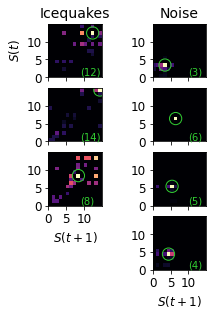

In [74]:





plt.figure(figsize=(width1,height1))

nRows = nR = 4
nCols = nC = 2

# fig, axes = plt.subplots(nRows,nCols)

gs = gridspec.GridSpec(nRows,nCols)

gs.update(wspace=0, hspace=0.2)

    
tfont = 14
symbolSize = 150    
shift = .4 #shift marker for selected states 

for i, evID in enumerate(catRep1.event_ID):


    ax=plt.subplot(gs[i,0])
    ax.set_aspect('equal')
    if i==0:
        ax.set_title('Icequakes',fontsize=tfont)
        ax.set_ylabel('$S(t)$',fontsize=tfont-2)
        
    else:
        ax.set_ylabel('')
        

        
    #normalize fps by local max
    fp = getFP(evID,path_proj,outfile_name) 
    fp = fp / np.max(fp)
        

    ## plot FP
    plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')

    
    

    ## plot symbol on key states

    plt.scatter(sel_state[i][1]+shift,
                sel_state[i][0]+shift,
                symbolSize,
                edgecolors='limegreen',
                color='None',
                marker='o',
                linewidths=1)    

    ax.text(9,.5,f'({sel_state[i][0]})',color='limegreen',size=10)
    
    #ticks
    plt.yticks(ticks = [0,5,10],labels=['0','5','10'])
    plt.xticks(ticks = [0,5,10],labels=['0','5','10'])

    #labels
    if i == Kopt-1:
        ax.set_xlabel('$S(t+1)$',fontsize=tfont-2)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    i == Kopt-1
        
    

    
    
for i, evID in enumerate(catRep1N.event_ID):


    ax=plt.subplot(gs[i,1])
    ax.set_aspect('equal')
    if i==0:        
        ax.set_title('Noise',fontsize=tfont)

#     ax.axis('off')
    #normalize fps by local max
    fp = getFP(evID,path_projN,outfile_nameN) 
    fp = fp / np.max(fp)
        

    ## plot FP
    plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
    #colorbar
    
#     plt.colorbar(pad=.1, shrink=.6)

    ## plot symbol on key states

    plt.scatter(sel_stateN[i][1]+shift,
                sel_stateN[i][0]+shift,
                symbolSize,
                edgecolors='limegreen',
                color='None',
                marker='o',
                linewidths=1)    

    
    ax.text(10,.5,f'({sel_stateN[i][0]})',color='limegreen',size=10)
    ##ticks
    plt.yticks(ticks = [0,5,10],labels=['0','5','10'])
    plt.xticks(ticks = [0,5,10],labels=['0','5','10'])

    #labels
    #labels
    if i == KoptN-1:
        ax.set_xlabel('$S(t+1)$',fontsize=tfont-2)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
        

    
    
plt.savefig(pathFig + f'Figure_11.pdf',bbox_inches='tight')


## plot colorbar


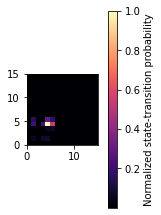

In [75]:


plt.rcParams.update({'font.size': 10})


plt.figure(figsize=(width1,height1))

gs = gridspec.GridSpec(nRows,nCols)

ax=plt.subplot(gs[:,1])

plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
plt.colorbar(pad=.1, shrink=.8,label='Normalized state-transition probability')



ax.set_aspect('equal')
plt.savefig(pathFig + f'Figure_11_colorbar.pdf',bbox_inches='tight')

# Figure 12 - Reconstructed spectra

## Find scaling factors

In [72]:

k=3
peak_rec_state, peak_spec, scale = CalcDiffPeak(path_proj,cat00,k,RMM,sel_state_single,station)
kN=1
peak_rec_stateN, peak_specN, scaleN = CalcDiffPeak(path_projN,cat00N,kN,RMMN,sel_state_singleN,station)


In [77]:
len(tSTFT),len(tSTFTN)

(33, 72)

## reconstructed spectra with median 

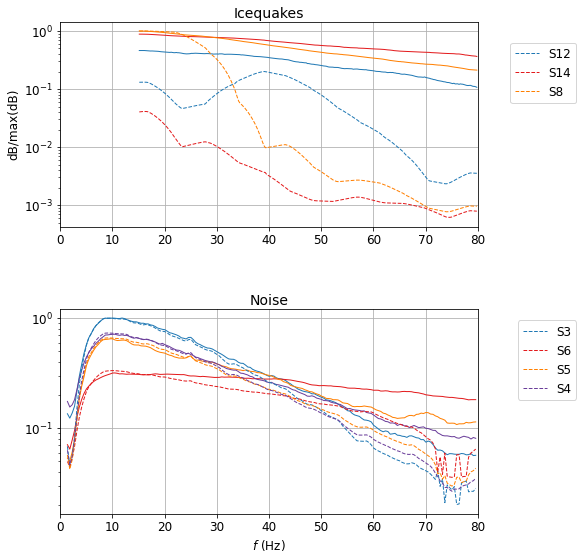

In [76]:
plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2,1)
gs.update(wspace=.4, hspace=.4)
leg = legN = ['','','','','','','','','','','']

title='Icequakes'
titleN='Noise'

tpad=4


### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
ax = plt.subplot(gs[0])
ax.set_xlim(0,80)

ax.set_title(title,fontsize=tfont,pad=tpad)
  


lw=.5
alpha=.3






figureFunctions2.plotMedianSpectra(path_proj,cat00,Kopt,fSTFT,station,leg,normed='median',ax=ax,scale=peak_spec,**plt_kwargs)

figureFunctions2.plotReconstructedStates(RMM,
                                         sel_state_single,
                                         fSTFT,
                                         lw=1,
                                         legend='outside',
                                         bb1=1.25,
                                         bb2=.75,                                         
                                         freq_list=None,
                                         normed='median',
                                         ax=ax,
                                         scale=peak_rec_state,
                                         **plt_kwargs)



    
    

ax.set_ylabel('dB/max(dB)')
ax.set_xlabel('')



plt.yscale('log')
# plt.xscale('log')





### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
ax = plt.subplot(gs[1])
ax.set_xlim(0,80)

ax.set_title(titleN,fontsize=tfont,pad=tpad)
  




figureFunctions2.plotMedianSpectra(path_projN,
                                   cat00N,
                                   KoptN,
                                   fSTFTN,
                                   station,
                                   leg,
                                   normed='median',
                                   ax=ax,
                                   scale=peak_specN,
                                   **plt_kwargs)



figureFunctions2.plotReconstructedStates(RMMN,
                                         sel_state_singleN,
                                         fSTFTN,
                                         lw=1,
                                         legend='outside',
                                         bb1=1.25,
                                         bb2=.75,                                         
                                         freq_list=None,
                                         normed='median',
                                         ax=ax,
                                         scale=peak_rec_stateN,
                                         **plt_kwargs)

    
    

ax.set_ylabel('')
ax.set_xlabel('$f$ (Hz)')



plt.yscale('log')
# plt.xscale('log')







plt.savefig(pathFig + f'Figure_12.png',bbox_inches='tight')

In [ ]:
# def CalcDiffPeak_Cluster(catRep,k,RMM,sel_state,station,path_proj):
#     """
#     For cluster k, divide max of Rep spectra by median of maxes of top representative spectra
#     """
    
    
#     maxAmp_list = []
    
    
#     # for Rep catalog of cluster k, get list of maxes of spectra
#     catRepK = catRep[catRep.Cluster==k]
#     for i, evID in enumerate(catRepK.event_ID):      
#         spectra, __ = getSpectra(evID,station,path_proj,normed=True)
#         maxAmp_list.append(np.max(spectra))
            
#     maxAmp_list_array = np.array(maxAmp_list)
    
#     medianMaxAmp = np.median(maxAmp_list_array)
                    
#     ## get max value of reconstructed spectra from selected stated
#     rec_state = RMM[:,sel_state[k-1]]
#     maxRecSpec = np.max(rec_state) 



#     scale = maxRecSpec / medianMaxAmp

#     return scale

# k=1
# scale = CalcDiffPeak_Cluster(catRep,k,RMM,sel_state,station,path_proj)
# scale